# ECG basics

## What is in an ECG?


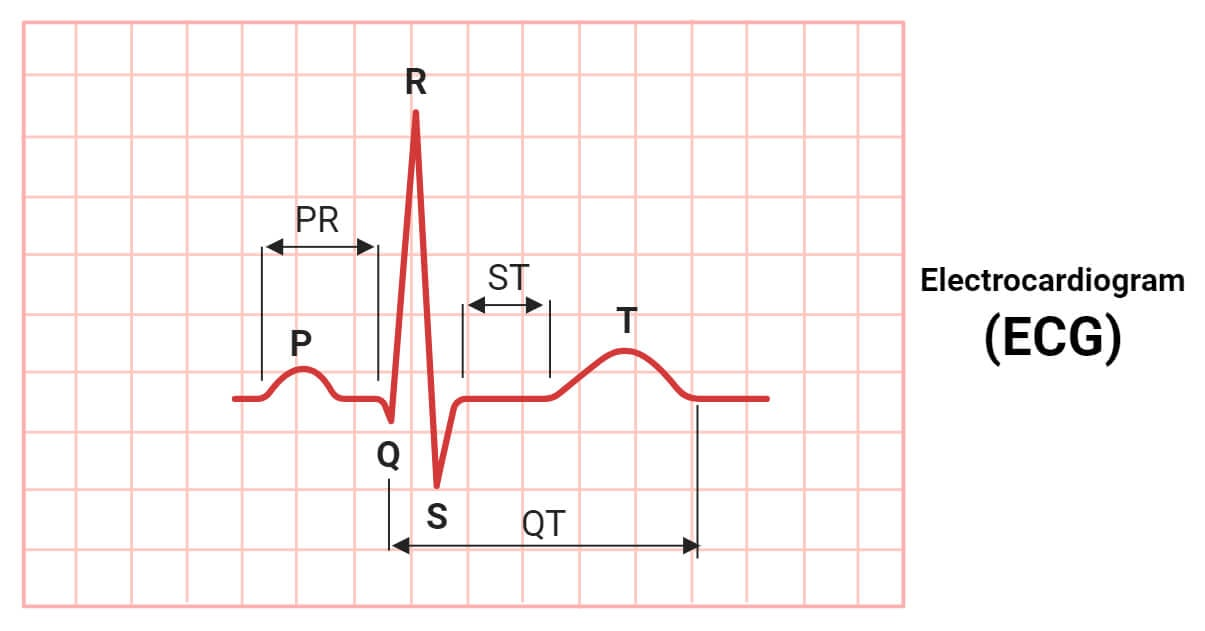


* **Waveform pieces:** **P wave** (atrial depolarization), **QRS** complex (ventricular depolarization), **T wave**(ventricular repolarization).
* **Useful time scales:** QRS is sharp (~60–120 ms), P and T are broader (100–250 ms).
* **Sampling:** Common rates are 250, 360, 500, or 1 kilo Hz. The CNN must "see" enough points to resolve the narrow QRS peaks.


## Practical preprocessing for ECG (what a CNN benefits from)

* **DC removal / baseline wander correction:** high-pass (e.g., 0.5 Hz) or polynomial detrend.
* **Powerline notch:** 50/60 Hz notch if needed.
* **Normalization:** This stabilizes optimization.Per-record z-score given by the following equation:

$$
\tilde{x}_t = \dfrac{x_t - \mu}{\sigma+\varepsilon}
$$


* **Segmentation:** either fixed windows (e.g., 2–5 s) or beat-centered (R-peak aligned); **label** at window/beat level accordingly.
* **Class imbalance handling:** compute class weights or resample.

---


# CNN related theory for ECG for this assignment

## **1D Convolution for ECG**

A **1D convolution** is used for **sequential data** like ECG, speech, or time series.
For an input sequence $x(t)$ and kernel $w(k)$:

$$
y(t) = \sum_{k=0}^{K-1} w(k) , x(t - k)
$$

It extracts **temporal patterns** (for e.g., QRS complexes in ECG) by sliding filters over time.

---

## **Dilated Convolution**

A **dilated (or atrous) convolution** introduces **gaps** between kernel elements, allowing a wider **receptive field** without increasing parameters.

$$
y(t) = \sum_{k=0}^{K-1} w(k) , x(t - r \cdot k)
$$

where **r** is the **dilation rate**.

* **r = 1** → standard convolution
* **r = 2** → skips one element between each filter weight
* **r = 4, 8, ...** → exponentially larger receptive field

**Why is dilation important for ECGs?**
* ECG events (like P, QRS, T) occur over varying time scales.
* Dilations let the model detect **short- and long-range temporal dependencies** simultaneously.

---


## **Residual Connections (ResNet Idea)**

_Residual blocks_ solve the **vanishing gradient problem** by adding **skip connections**:

$$
y = F(x) + x
$$

* $F(x)$: non-linear transformation (like convolutions)
* $x$: shortcut identity mapping

This allows **gradient flow** directly through identity paths and lets the network learn **refinements** rather than full mappings. This is crucial for deep models.

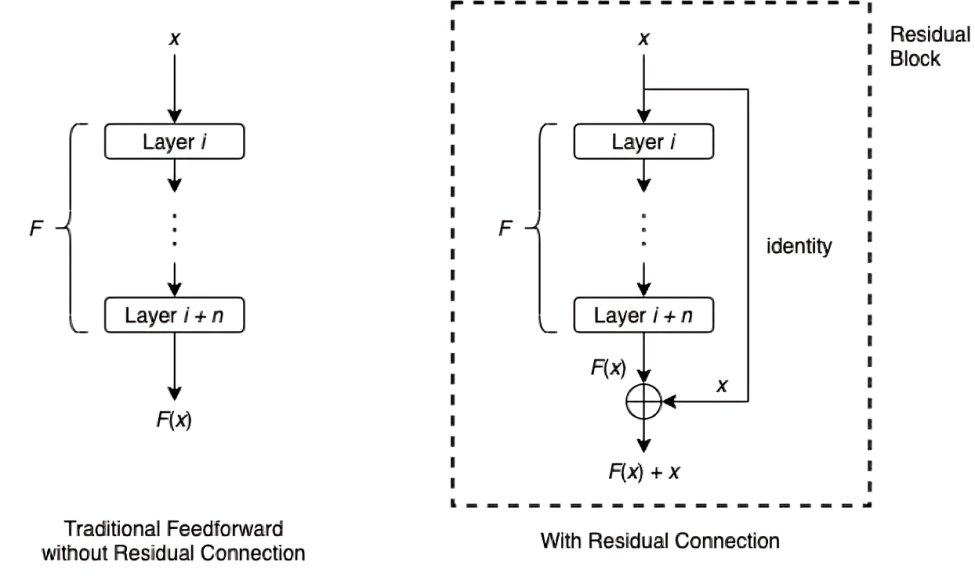

---


## **Normalization Layers**

1. **Batch Normalization (BN):**
   Normalizes each feature across the batch:
   $$
   \hat{x} = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
   $$
   This stabilizes training, enabling higher learning rates.

2. **Group Normalization (GN):**
   Divides channels into groups and normalizes within each group.
   Works better for **small batch sizes**, which is common in biomedical signals.

---


## **Dropout Regularization**

Randomly sets some activations to zero with probability `p` during training to prevent **overfitting**.

---


## **Architectural Design**
Refer the code in the assignment below to understand the architecture described below in the next cell.

### **DilatedResBlock**

Each block:

* Two convolutional layers (3 x 1 then 1 x 1)
* Dilation applied in the first conv
* Normalization + ReLU activation
* Dropout
* Residual connection (`+x`)
* Final ReLU

**Purpose:** learns multi-scale temporal patterns while preserving the original signal path.

---

### **ECGDilatedCNN**

The model consists of:

1. **Stem Block**

   ```
   Conv1d(1→32, kernel=3) → BN → ReLU → MaxPool1d(2)
   ```

   * Converts 1-channel ECG input into feature maps.
   * Downsamples signal by factor of 2.

2. **Dilated Residual Blocks**

   * Stacked with different dilations: (1, 2, 4, 8)
   * Expands receptive field exponentially (covers hundreds of timesteps).

3. **Head**

   ```
   AdaptiveAvgPool1d(1) → Flatten → Linear(32→num_classes)
   ```

   * Global average pooling captures full-signal context.
   * Linear layer classifies into 5 ECG classes.

**Intuition:**
Progressively learn temporal dependencies from local to global context, like detecting wave morphology and rhythm patterns.

---

## Summary of rationale for model design

* **Dilations** capture both local QRS complexes and long inter-beat intervals.
* **Residual paths** maintain raw ECG signal integrity.
* **1D convolutions** suit the sequential, univariate ECG structure.
* **Global pooling** ensures invariance to signal length or sampling artifacts.

Together, this design approximates a **temporal feature extractor** with **multi-scale perception**, ideal for ECG-based classification tasks like arrhythmia detection.

---



# Assignment 2 - Listening to the Heart (ECG5000, 1D CNN with Dilation)

**Storyline**
* You’re prototyping an embedded arrhythmia detector.
* Temporal context must be large, but model must remain small.

**Concept focus**
* Conv1d
* Dilated Convolution
* Residual Learning
* BatchNorm1d vs LayerNorm
* Robustness to noise.

**Deliverables**
Add relevant cells at the end of this notebook for the following:
1. Plot Ablations for dilation schedules (1,2,4,8) vs (1,2,4) and Batch vs Layer Normalization.
2. Robustness test: add Gaussian noise (σ ∈ {0.01, 0.05, 0.1}) and report accuracy.


In [1]:

#@title Setup
!pip -q install torch torchvision --progress-bar off
import torch, torch.nn as nn, numpy as np, pandas as pd, os, urllib.request, zipfile
from torch.utils.data import Dataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Device: cpu


In [2]:
# Download the dataset from "https://timeseriesclassification.com/aeon-toolkit/ECG5000.zip"
# Unzip it's contents and upload it in a folder named "ECG5000" before going any further

In [2]:
#@title Load train/test into PyTorch Dataset
def load_ucr(fp):
    arr = np.loadtxt(fp)
    y = arr[:,0].astype(int) - 1  # labels 0..4
    X = arr[:,1:].astype(np.float32)
    return X, y

Xtr, ytr = load_ucr("./ECG5000/ECG5000_TRAIN.txt")
Xte, yte = load_ucr("./ECG5000/ECG5000_TEST.txt")

class ECG(Dataset):
    def __init__(self, X, y): self.X=torch.from_numpy(X)[:,None,:]; self.y=torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_dl = DataLoader(ECG(Xtr,ytr), batch_size=128, shuffle=True)
test_dl  = DataLoader(ECG(Xte,yte), batch_size=256, shuffle=False)
print("Shapes:", next(iter(train_dl))[0].shape)


Shapes: torch.Size([128, 1, 140])


In [15]:
#@title Model: Dilated Residual 1D CNN
class DilatedResBlock(nn.Module):

    def __init__(self, ch, k=3, dilation=1, drop=0.1, norm="bn"):
        super().__init__()

        pad = (k-1) // 2 * dilation

        Norm = (lambda c: nn.BatchNorm1d(c)) if norm=="bn" else (lambda c: nn.GroupNorm(1,c))

        self.net = nn.Sequential(
            nn.Conv1d(ch, ch, k, padding=pad, dilation=dilation, bias=False),
            Norm(ch),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv1d(ch, ch, 1, bias=False),
            Norm(ch)
        )
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.net(x) + x)


class ECGDilatedCNN(nn.Module):
    def __init__(self, num_classes=5, base=32, drop=0.1, norm="bn", dilations=(1,2,4,8)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(1, base, 3, padding=1, bias=False),
            nn.BatchNorm1d(base),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        blocks = []
        for d in dilations:
            blocks += [DilatedResBlock(base, k=3, dilation=d, drop=drop, norm=norm)]
        self.blocks = nn.Sequential(*blocks)
        self.head = nn.Sequential(
                        nn.AdaptiveAvgPool1d(1),
                        nn.Flatten(),
                        nn.Linear(base, num_classes)
                    )

    def forward(self, x):
        return self.head(self.blocks(self.stem(x)))



In [16]:
#@title Train and Evaluate
def train(model, epochs=12, lr=3e-4):

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for ep in range(1, epochs+1):
        model.train()
        tr_loss = tr_acc = n = 0

        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            o = model(x)
            loss = loss_fn(o, y)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * x.size(0)
            tr_acc += (o.argmax(1)==y).sum().item()
            n += x.size(0)

        model.eval()

        va_loss = va_acc = m = 0

        with torch.no_grad():
            for x, y in test_dl:
                x, y = x.to(device), y.to(device)
                o = model(x)
                loss = loss_fn(o,y)
                va_loss += loss.item() * x.size(0)
                va_acc += (o.argmax(1)==y).sum().item()
                m += x.size(0)
        train_losses.append(tr_loss/n)
        train_accs.append(tr_acc/n)
        val_losses.append(va_loss/m)
        val_accs.append(va_acc/m)

        print(f"ep{ep:02d}  train {tr_loss/n:.4f}/{tr_acc/n:.3f}  val {va_loss/m:.4f}/{va_acc/m:.3f}")

    return train_losses, train_accs, val_losses, val_accs


1. Plot Ablations for dilation schedules (1,2,4,8) vs (1,2,4) and Batch vs Layer Normalization.

In [17]:

#@title Run baseline (BN, dilations=1,2,4,8)
model_d1_bn = ECGDilatedCNN(norm="bn", dilations=(1,2,4,8)).to(device)
train_losses_d1_bn, train_accs_d1_bn, val_losses_d1_bn, val_accs_d1_bn = train(model_d1_bn, epochs=12, lr=3e-4)

model_d2_bn = ECGDilatedCNN(norm="bn", dilations=(1,2,4)).to(device)
train_losses_d2_bn, train_accs_d2_bn, val_losses_d2_bn, val_accs_d2_bn = train(model_d2_bn, epochs=12, lr=3e-4)

model_d1_ln = ECGDilatedCNN(norm="ln", dilations=(1,2,4,8)).to(device)
train_losses_d1_ln, train_accs_d1_ln, val_losses_d1_ln, val_accs_d1_ln = train(model_d1_ln, epochs=12, lr=3e-4)

model_d2_ln = ECGDilatedCNN(norm="ln", dilations=(1,2,4)).to(device)
train_losses_d2_ln, train_accs_d2_ln, val_losses_d2_ln, val_accs_d2_ln = train(model_d2_ln, epochs=12, lr=3e-4)


ep01  train 1.3342/0.354  val 1.4404/0.353
ep02  train 1.1642/0.408  val 1.3495/0.580
ep03  train 1.0513/0.680  val 1.2626/0.584
ep04  train 0.9434/0.870  val 1.1736/0.819
ep05  train 0.8513/0.888  val 1.0763/0.880
ep06  train 0.7709/0.892  val 0.9676/0.884
ep07  train 0.6980/0.896  val 0.8530/0.887
ep08  train 0.6379/0.894  val 0.7456/0.889
ep09  train 0.5841/0.904  val 0.6564/0.891
ep10  train 0.5409/0.900  val 0.5837/0.894
ep11  train 0.5083/0.902  val 0.5249/0.896
ep12  train 0.4806/0.900  val 0.4826/0.899
ep01  train 2.0008/0.006  val 1.7431/0.005
ep02  train 1.8072/0.016  val 1.7159/0.005
ep03  train 1.6475/0.254  val 1.6769/0.005
ep04  train 1.5036/0.442  val 1.6217/0.051
ep05  train 1.3768/0.688  val 1.5477/0.343
ep06  train 1.2641/0.802  val 1.4542/0.409
ep07  train 1.1573/0.836  val 1.3458/0.670
ep08  train 1.0707/0.864  val 1.2242/0.786
ep09  train 0.9788/0.868  val 1.1057/0.825
ep10  train 0.9054/0.878  val 0.9903/0.852
ep11  train 0.8398/0.884  val 0.8889/0.869
ep12  train

In [8]:
!pip install plotly


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot grid
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy")
)

epochs = list(range(1, len(train_losses_d1_bn) + 1))

# TRAINING LOSS 
fig.add_trace(go.Scatter(x=epochs, y=train_losses_d1_bn, mode='lines+markers',
                         name='BN (1,2,4,8)', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_losses_d2_bn, mode='lines+markers',
                         name='BN (1,2,4)', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_losses_d1_ln, mode='lines+markers',
                         name='LN (1,2,4,8)', line=dict(color='green')), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_losses_d2_ln, mode='lines+markers',
                         name='LN (1,2,4)', line=dict(color='red')), row=1, col=1)

# VALIDATION LOSS
fig.add_trace(go.Scatter(x=epochs, y=val_losses_d1_bn, mode='lines+markers',
                         name='BN (1,2,4,8)', line=dict(color='blue', dash='dot')), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_losses_d2_bn, mode='lines+markers',
                         name='BN (1,2,4)', line=dict(color='orange', dash='dot')), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_losses_d1_ln, mode='lines+markers',
                         name='LN (1,2,4,8)', line=dict(color='green', dash='dot')), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_losses_d2_ln, mode='lines+markers',
                         name='LN (1,2,4)', line=dict(color='red', dash='dot')), row=1, col=2)

# TRAINING ACCURACY 
fig.add_trace(go.Scatter(x=epochs, y=train_accs_d1_bn, mode='lines+markers',
                         name='BN (1,2,4,8)', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_accs_d2_bn, mode='lines+markers',
                         name='BN (1,2,4)', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_accs_d1_ln, mode='lines+markers',
                         name='LN (1,2,4,8)', line=dict(color='green')), row=2, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_accs_d2_ln, mode='lines+markers',
                         name='LN (1,2,4)', line=dict(color='red')), row=2, col=1)

# VALIDATION ACCURACY 
fig.add_trace(go.Scatter(x=epochs, y=val_accs_d1_bn, mode='lines+markers',
                         name='BN (1,2,4,8)', line=dict(color='blue', dash='dot')), row=2, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_accs_d2_bn, mode='lines+markers',
                         name='BN (1,2,4)', line=dict(color='orange', dash='dot')), row=2, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_accs_d1_ln, mode='lines+markers',
                         name='LN (1,2,4,8)', line=dict(color='green', dash='dot')), row=2, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_accs_d2_ln, mode='lines+markers',
                         name='LN (1,2,4)', line=dict(color='red', dash='dot')), row=2, col=2)

# LAYOUT SETTINGS 
fig.update_layout(
    title="BatchNorm vs LayerNorm with Different Dilation Configurations",
    height=800, width=1100,
    template="plotly_dark",
    showlegend=True
)

fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Value")

fig.show()


2. Robustness test: add Gaussian noise (σ ∈ {0.01, 0.05, 0.1}) and report accuracy.

In [20]:
#@title Train and Evaluate
def train_custom_train_dl(model, epochs=12, lr=3e-4, train_dl=train_dl):

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for ep in range(1, epochs+1):
        model.train()
        tr_loss = tr_acc = n = 0

        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            o = model(x)
            loss = loss_fn(o, y)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * x.size(0)
            tr_acc += (o.argmax(1)==y).sum().item()
            n += x.size(0)

        model.eval()

        va_loss = va_acc = m = 0

        with torch.no_grad():
            for x, y in test_dl:
                x, y = x.to(device), y.to(device)
                o = model(x)
                loss = loss_fn(o,y)
                va_loss += loss.item() * x.size(0)
                va_acc += (o.argmax(1)==y).sum().item()
                m += x.size(0)
        train_losses.append(tr_loss/n)
        train_accs.append(tr_acc/n)
        val_losses.append(va_loss/m)
        val_accs.append(va_acc/m)

        print(f"ep{ep:02d}  train {tr_loss/n:.4f}/{tr_acc/n:.3f}  val {va_loss/m:.4f}/{va_acc/m:.3f}")

    return train_losses, train_accs, val_losses, val_accs


In [27]:
import numpy as np
import torch
from torch.utils.data import DataLoader

for sigma in [0.01, 0.05, 0.10]:

    # Add Gaussian noise using NumPy
    Xte_noisy = Xte + np.random.normal(0, sigma, Xte.shape)
    Xte_noisy = np.clip(Xte_noisy, 0.0, 1.0)

    # Convert to float32 (PyTorch expects this type)
    Xte_noisy = Xte_noisy.astype(np.float32)

    # Create dataloader
    test_dl = DataLoader(ECG(Xte_noisy, yte), batch_size=256, shuffle=False)

    # Evaluate model accuracy
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            preds = model_d1_bn(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"Noise σ={sigma:.2f} → Accuracy: {acc:.3f}")


Noise σ=0.01 → Accuracy: 0.387
Noise σ=0.05 → Accuracy: 0.448
Noise σ=0.10 → Accuracy: 0.542
